In [1]:
 %load_ext autoreload

In [56]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bert_score import score
from moverscore_v2 import get_idf_dict, word_mover_score 
from collections import defaultdict

os.environ['CUDA_VISIBLE_DEVICES']='3'
pd.set_option('display.max_colwidth', None)
sys.path.append('/workspace/computationally-undermining-arguments/scripts/')
sys.path.append('/workspace/computationally-undermining-arguments/src-py')
sys.path.append('/workspace/computationally-undermining-arguments/thirdparty/transfer-learning-conv-ai/')

In [191]:
%autoreload
import evaluation
import json
import utility
from argparse import Namespace
from tabulate import tabulate

In [40]:
testing_df  = pd.read_pickle('./testing_df.pkl')
expanded_df = pd.read_pickle('./expanded_df.pkl')

In [170]:
testing_df[['app_v2']].head()

,app_v2
108600,"[[[if you agree with this, my point is, this does not connect at all to our perception of good., if it did, god would not allow insert horrible event that happens daily in real life and encourage insert horrible bible verse about slavery women war punishment .], you have a really weird view of good and bad. if you think that the world is inherently bad, and your viewpoint is wrong, maybe you shouldn't have your view changed to reflect this view. but then there is a good reason to believe that heaven and hell are both bad. and that there is no good in them. you can't blame'bad'god for their existence.]]"
105230,"[[[i. e. , the central bank gives money to your local bank so your local bank can lend it to you at low cost.], can you elaborate on why you think this? if your first argument is that inflation is increasing, i will definitely dispute that. the main problem is that people are constantly looking at the stock market, trying to figure out how the stock market can function. in the process, people can buy or buy bonds for a reason. it is very possible that the market is getting smaller, and that the market is getting larger.], [[the problem with this logic is it results in wage growth being the last benefactor of all this cheap money if at all.], where are the profits for this? why can't the government pay wages higher if people are working to increase the wage of their income? if there is a demand for'low interest rates'and they don't get any interest, then the average person would be low in wage and unable to move money around to pay prices. you aren't taking any of these into account. as it stands, the stock market is not rising, and the market is still growing.]]"
109572,"[[[4 accepting lgbt might mean accepting other degenerates if we accept these people today who guarantees we arent accepting zoophiles and pedos tomorrow?], because they didn't want to be trans, which is the exact opposite of the lgbt issue, which you were referring to earlier. it's also not about allowing homosexuals to live in society. they want to be around and provide for them, a place for their children and, most importantly, for the general population. in order for such things to happen, they need to be able to make a living from it, including working to pay for what they do. you seem to think this's a deal breaker, but it's not.]]"
110783,"[[[i think beastiality should be illegal only because it disgusts me, as ridiculous as that sounds.], why? if you find something disgusting and you find it disgusting, but you're still ok with doing so, why should people find it morally wrong. is that not your view? is it your moral position to kill animals because you think it disgusts you? if you think it disgusts me, then you can't justify any of it.]]"
103458,"[[[there are 500m who do nothing but send transactions and eat salmon and all the other people are cooking the salmon and making sure the transaction goes well.], how are you quantifying 500m of wealth? most people don't know what 500m is, or the number of hours it takes to feed, feed, and feed a single person. the total amount of money you spend at work has nothing to do with the amount of money you save. it is entirely possible for a person to make 50, 000 a year and not do anything else besides just do it on the off chance you are in that position for the rest of their life. there are still a number of people who are good at something even if they are terrible at it.]]"


In [173]:
len(testing_df)

1000

In [5]:
def eval_model_on_df(df_gt, df_preds):
    bleu_1, bleu1_scores = evaluation.eval_bleu(df_gt, df_preds, weights=(1,0,0,0))
    bleu, bleu_scores  = evaluation.eval_bleu(df_gt, df_preds, weights=(0.5, 0.5,0,0))
    meteor, meteor_scores = evaluation.eval_meteor(df_gt, df_preds)
    return [meteor, bleu_1, bleu], [bleu1_scores, bleu_scores, meteor_scores]

In [33]:
def eval_multiple_preds(df, pred_clms, gt_clm):
    gt_texts = df[gt_clm].tolist()
    
    bleu1_evals  = []
    bleu_evals   = []
    meteor_evals = []
    
    for clm in pred_clms:
        bleu1_evals.append(evaluation.eval_bleu(gt_texts, df[clm].tolist(), weights=(1,0,0,0)))
        bleu_evals.append(evaluation.eval_bleu(gt_texts, df[clm].tolist(), weights=(0.5, 0.5,0,0)))
        meteor_evals.append(evaluation.eval_meteor(gt_texts, df[clm].tolist()))
    
    bleu1_score = round(np.mean([x[0] for x in bleu1_evals]), 3)
    bleu_score = round(np.mean([x[0] for x in bleu_evals]), 3)
    meteor_score = round(np.mean([x[0] for x in meteor_evals]), 3)
    
    bleu1_scores  = np.mean([x[1] for x in bleu1_evals], axis=0)
    bleu_scores   = np.mean([x[1] for x in bleu_evals], axis=0)
    meteor_scores = np.mean([x[1] for x in meteor_evals], axis=0)
    
    return [meteor_score, bleu1_score, bleu_score], [bleu1_scores, bleu_scores, meteor_scores]

In [209]:
def choose_best_match(df, pred_clm, gt_clm):
    pred_attacks = df[pred_clm].tolist()
    gt_attacks   = df[gt_clm].tolist()
    
    best_preds = []
    for post_pred_attacks, post_gt_attacks in zip(pred_attacks, gt_attacks):
        attack_overlaps = [utility.overlap_between_attack_and_attacked_premises(weak_premise, attack) for weak_premise, attack in post_pred_attacks]
        best_attack_idx = attack_overlaps.index(max(attack_overlaps))
        best_attack = post_pred_attacks[best_attack_idx]
        gt_attack   = post_gt_attacks[best_attack_idx]
        best_preds.append([best_attack[0], best_attack[1], gt_attack[1]])

    return best_preds

In [210]:
testing_df['app_v2_best_match'] = choose_best_match(testing_df, 'app_v2', 'premise_counter_premise_pairs')
testing_df['app_v3_best_match'] = choose_best_match(testing_df, 'app_v3', 'premise_counter_premise_pairs')
testing_df['baseline_best_match'] = choose_best_match(testing_df, 'baseline_final', 'premise_counter_premise_pairs')

In [215]:
_, app_v2_gt, app_v2_pred = zip(*testing_df.app_v2_best_match.tolist())
tmp_app_v2_score, tmp_app_v2_scores = eval_model_on_df(app_v2_gt, app_v2_pred)

In [216]:
_, app_v3_gt, app_v3_pred = zip(*testing_df.app_v3_best_match.tolist())
tmp_app_v3_score, tmp_app_v3_scores = eval_model_on_df(app_v3_gt, app_v3_pred)

In [217]:
_, baseline_gt, baseline_pred = zip(*testing_df.baseline_best_match.tolist())
tmp_baseline_score, tmp_baseline_scores = eval_model_on_df(baseline_gt, baseline_pred)

In [218]:
print(tabulate([
        ['1. Baseline'] + tmp_baseline_score,
        ['2. Ours v2'] + tmp_app_v2_score,
        ['3. Ours v3'] + tmp_app_v3_score,
       ], headers=['Approach', 'meteor', 'bleu-1', 'bleu-1&2']))

Approach       meteor    bleu-1    bleu-1&2
-----------  --------  --------  ----------
1. Baseline     0.067    12.646       3.042
2. Ours v2      0.066    13.139       3.395
3. Ours v3      0.067    12.888       3.274


### Evaluate model's predictions against the ground-truth premises:

#### Evalute model:

In [156]:
baseline_evals, baseline_scores= eval_model_on_df(expanded_df.gt_counter.tolist(), expanded_df.baseline_final.tolist())
app_v2_evals, app_v2_scores = eval_model_on_df(expanded_df.gt_counter.tolist(), expanded_df.app_v2.tolist())
app_v3_evals, app_v3_scores = eval_model_on_df(expanded_df.gt_counter.tolist(), expanded_df.app_v3.tolist())
app_v4_evals, app_v4_scores = eval_model_on_df(expanded_df.gt_counter.tolist(), expanded_df.app_v4.tolist())

#### Evaluate title:

In [159]:
app_v2_title_evals, app_v2_title_scores = eval_model_on_df(expanded_df.gt_counter.tolist(), expanded_df.app_v2_title.tolist())
app_v3_title_evals, app_v3_title_scores = eval_model_on_df(expanded_df.gt_counter.tolist(), expanded_df.app_v3_title.tolist())

In [160]:
app_v4_title_evals, app_v4_title_scores = eval_model_on_df(expanded_df.gt_counter.tolist(), expanded_df.app_v4_title.tolist())

#### Evaluate Random:

In [161]:
app_v2_random_baseline_evals, app_v2_random_baseline_scores = eval_multiple_preds(expanded_df, ['app_v2_rand_0', 'app_v2_rand_1', 'app_v2_rand_2'], 'gt_counter')
app_v3_random_baseline_evals, app_v3_random_baseline_scores = eval_multiple_preds(expanded_df, ['app_v3_rand_0', 'app_v3_rand_1', 'app_v3_rand_2'], 'gt_counter')

In [162]:
app_v4_random_baseline_evals, app_v4_random_baseline_scores = eval_multiple_preds(expanded_df, ['app_v4_rand_0', 'app_v4_rand_1', 'app_v4_rand_2'], 'gt_counter')

### Evaluate model's predictions against the ground-truth comments:

In [23]:
baseline_evals_against_args, baseline_scores_against_args= eval_model_on_df(expanded_df.all_counter_arguments.tolist(), expanded_df.baseline_final)
app_v2_evals_against_args, app_v2_scores_against_args = eval_model_on_df(expanded_df.all_counter_arguments.tolist(), expanded_df.app_v2.tolist())
app_v3_evals_against_args, app_v3_scores_against_args = eval_model_on_df(expanded_df.all_counter_arguments.tolist(), expanded_df.app_v3.tolist())

In [45]:
app_v4_evals_against_args, app_v4_scores_against_args = eval_model_on_df(expanded_df.all_counter_arguments.tolist(), expanded_df.app_v4.tolist())

In [24]:
app_v2_random_baseline_evals_against_args, app_v2_random_baseline_scores_against_args = eval_multiple_preds(expanded_df, ['app_v2_rand_0', 'app_v2_rand_1', 'app_v2_rand_2'], 'all_counter_arguments')
app_v3_random_baseline_evals_against_args, app_v3_random_baseline_scores_against_args = eval_multiple_preds(expanded_df, ['app_v3_rand_0', 'app_v3_rand_1', 'app_v3_rand_2'], 'all_counter_arguments')

In [46]:
app_v4_random_baseline_evals_against_args, app_v4_random_baseline_scores_against_args = eval_multiple_preds(expanded_df, ['app_v4_rand_0', 'app_v4_rand_1', 'app_v4_rand_2'], 'all_counter_arguments')

In [25]:
app_v2_title_evals_against_args, app_v2_title_scores_against_args = eval_model_on_df(expanded_df.all_counter_arguments.tolist(), expanded_df.app_v2_title.tolist())
app_v3_title_evals_against_args, app_v3_title_scores_against_args = eval_model_on_df(expanded_df.all_counter_arguments.tolist(), expanded_df.app_v3_title.tolist())

In [47]:
app_v4_title_evals_against_args, app_v4_title_scores_against_args = eval_model_on_df(expanded_df.all_counter_arguments.tolist(), expanded_df.app_v4_title.tolist())

In [167]:
print(tabulate([
                ['1. Baseline'] + baseline_evals + baseline_evals_against_args,
                ['2. Ours v2 - title'] + app_v2_title_evals + app_v2_title_evals_against_args,
                ['2. Ours v2 - random']+ app_v2_random_baseline_evals + app_v2_random_baseline_evals_against_args,
                ['2. Ours v2'] + app_v2_evals + app_v2_evals_against_args,
                ['3. Ours v3 - title'] + app_v3_title_evals + app_v3_title_evals_against_args,
                ['3. Ours v3 - random'] + app_v3_random_baseline_evals + app_v3_random_baseline_evals_against_args,
                ['3. Ours v3'] + app_v3_evals + app_v3_evals_against_args,
                #['4. Ours v4 - title'] + app_v4_title_evals + app_v4_title_evals_against_args,
                #['4. Ours v4 - random'] + app_v4_random_baseline_evals + app_v4_random_baseline_evals_against_args,
                #['4. Ours v4'] + app_v4_evals + app_v4_evals_against_args,
               ], headers=['Approach', 'meteor', 'bleu-1', 'bleu-1&2', 'meteor', 'bleu-1', 'bleu-1&2']))

Approach               meteor    bleu-1    bleu-1&2    meteor    bleu-1    bleu-1&2
-------------------  --------  --------  ----------  --------  --------  ----------
1. Baseline             0.058    13.023       3.117     0.097    10.4         3.212
2. Ours v2 - title      0.06     12.532       2.943     0.09      9.472       2.837
2. Ours v2 - random     0.058    12.838       3.005     0.096    10.398       3.255
2. Ours v2              0.057    13.453       3.391     0.102    10.998       3.764
3. Ours v3 - title      0.06     12.635       3.023     0.092     9.685       2.984
3. Ours v3 - random     0.059    12.712       2.987     0.096    10.161       3.217
3. Ours v3              0.058    13.162       3.217     0.101    10.743       3.651


In [223]:
# print(perform_significance_tests(baseline_scores, model_1_scores))
# print(perform_significance_tests(baseline_scores, model_2_scores))
# print(perform_significance_tests(baseline_scores, model_3_scores))
# print(perform_significance_tests(baseline_scores, model_4_scores))
# print(perform_significance_tests(baseline_scores, model_5_scores))
print('app2 vs baseline:')
print(perform_significance_tests(baseline_scores, app_v2_scores))
print(perform_significance_tests(baseline_scores_against_args, app_v2_scores_against_args))

app2 vs baseline:
{'bleu-1': {'@5%': True, '%10': True}, 'bleu': {'@5%': True, '%10': True}, 'meteor': {'@5%': False, '%10': False}}
{'bleu-1': {'@5%': True, '%10': True}, 'bleu': {'@5%': True, '%10': True}, 'meteor': {'@5%': True, '%10': True}}


In [165]:
print('app3 vs baseline:')
print(perform_significance_tests(baseline_scores, app_v3_scores))
print(perform_significance_tests(baseline_scores_against_args, app_v3_scores_against_args))

app3 vs baseline:
{'bleu-1': {'@5%': False, '%10': False}, 'bleu': {'@5%': False, '%10': False}, 'meteor': {'@5%': False, '%10': False}}
{'bleu-1': {'@5%': True, '%10': True}, 'bleu': {'@5%': True, '%10': True}, 'meteor': {'@5%': True, '%10': True}}


In [166]:
print('app4 vs baseline:')
print(perform_significance_tests(baseline_scores, app_v4_scores))
print(perform_significance_tests(baseline_scores_against_args, app_v4_scores_against_args))

app4 vs baseline:
{'bleu-1': {'@5%': False, '%10': False}, 'bleu': {'@5%': False, '%10': False}, 'meteor': {'@5%': False, '%10': False}}
{'bleu-1': {'@5%': True, '%10': True}, 'bleu': {'@5%': True, '%10': True}, 'meteor': {'@5%': False, '%10': True}}


In [147]:
print('app2 vs app3:')
print(perform_significance_tests(app_v3_scores, app_v2_scores))
print(perform_significance_tests(app_v3_scores_against_args, app_v2_scores_against_args))

app2 vs app3:
{'bleu-1': {'@5%': True, '%10': True}, 'bleu': {'@5%': False, '%10': False}, 'meteor': {'@5%': True, '%10': True}}
{'bleu-1': {'@5%': False, '%10': True}, 'bleu': {'@5%': False, '%10': False}, 'meteor': {'@5%': True, '%10': True}}


In [149]:
print('app2 vs appv2 random:')
print(perform_significance_tests(app_v2_scores, [x[0] for x in app_v2_random_baseline_scores]))
print(perform_significance_tests(app_v2_scores_against_args, [x[0] for x in  app_v2_random_baseline_scores_against_args]))

app2 vs appv2 random:
{'bleu-1': {'@5%': False, '%10': False}, 'bleu': {'@5%': True, '%10': True}, 'meteor': {'@5%': False, '%10': True}}
{'bleu-1': {'@5%': False, '%10': False}, 'bleu': {'@5%': False, '%10': False}, 'meteor': {'@5%': False, '%10': False}}


In [150]:
print('app3 vs appv3 random:')
print(perform_significance_tests(app_v3_scores, [x[0] for x in app_v3_random_baseline_scores]))
print(perform_significance_tests(app_v3_scores_against_args, [x[0] for x in app_v3_random_baseline_scores]))

app3 vs appv3 random:
{'bleu-1': {'@5%': False, '%10': True}, 'bleu': {'@5%': False, '%10': False}, 'meteor': {'@5%': False, '%10': False}}
{'bleu-1': {'@5%': True, '%10': True}, 'bleu': {'@5%': True, '%10': True}, 'meteor': {'@5%': True, '%10': True}}


In [151]:
print('app2 vs appv2 title:')
print(perform_significance_tests(app_v2_scores, app_v2_title_scores))
print(perform_significance_tests(app_v2_scores_against_args, app_v2_title_scores_against_args))

app2 vs appv2 title:
{'bleu-1': {'@5%': False, '%10': False}, 'bleu': {'@5%': False, '%10': False}, 'meteor': {'@5%': False, '%10': False}}
{'bleu-1': {'@5%': False, '%10': False}, 'bleu': {'@5%': False, '%10': False}, 'meteor': {'@5%': False, '%10': False}}


In [152]:
print('app3 vs appv3 title:')
print(perform_significance_tests(app_v3_scores, app_v3_title_scores))
print(perform_significance_tests(app_v3_scores_against_args, app_v3_title_scores_against_args))

app3 vs appv3 title:
{'bleu-1': {'@5%': False, '%10': False}, 'bleu': {'@5%': False, '%10': False}, 'meteor': {'@5%': True, '%10': True}}
{'bleu-1': {'@5%': False, '%10': False}, 'bleu': {'@5%': False, '%10': False}, 'meteor': {'@5%': False, '%10': False}}


-------------

### Analyzing results:

In [389]:
def overlap_between_attack_and_attacked_premises(attacked_premises, attack):
    import nltk
    from nltk.corpus import stopwords
    en_stopwords = stopwords.words('english')

    attack_tokens =[token for token in nltk.word_tokenize(attack) if token not in en_stopwords]
    
    attacked_premise_tokens = []
    for sentence in attacked_premises:
        attacked_premise_tokens += [token for token in nltk.word_tokenize(sentence) if token not in en_stopwords]

    return len(set(attack_tokens).intersection(attacked_premise_tokens))/len(set(attacked_premise_tokens))

In [390]:
expanded_df['app2_overlap'] = expanded_df.apply(lambda row: overlap_between_attack_and_attacked_premises(row['premise'], row['app_v2']), axis=1)
expanded_df['app3_overlap'] = expanded_df.apply(lambda row: overlap_between_attack_and_attacked_premises(row['premise'], row['app_v3']), axis=1)
expanded_df['baseline_overlap'] = expanded_df.apply(lambda row: overlap_between_attack_and_attacked_premises(row['premise'], row['baseline_final']), axis=1)

In [391]:
print('baseline: ', round(np.mean(expanded_df['baseline_overlap'].tolist()), 2))
print('appv2: ', round(np.mean(expanded_df['app2_overlap'].tolist()), 2))
print('appv3: ', round(np.mean(expanded_df['app3_overlap'].tolist()), 2))

baseline:  0.22
appv2:  0.27
appv3:  0.27


<AxesSubplot:>

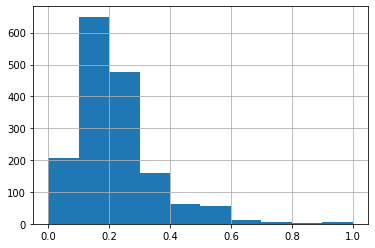

In [409]:
expanded_df.baseline_overlap.hist()

In [ ]:
expanded_df.baseline_overlap.tolist(), 
          expanded_df.app2_overlap.tolist(), expanded_df.app3_overlap.tolist()

In [412]:
np.histogram(expanded_df.baseline_overlap.tolist(), bins=np.arange(0, 1, 0.1))

(array([207, 650, 476, 161,  62,  55,  11,   6,   4]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))

In [413]:
np.histogram(expanded_df.app2_overlap.tolist(), bins=np.arange(0, 1, 0.1))

(array([144, 449, 499, 233, 131, 125,  29,   9,  10]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))

In [414]:
np.histogram(expanded_df.app3_overlap.tolist(), bins=np.arange(0, 1, 0.1))

(array([137, 467, 486, 240, 126, 115,  26,  19,  13]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))

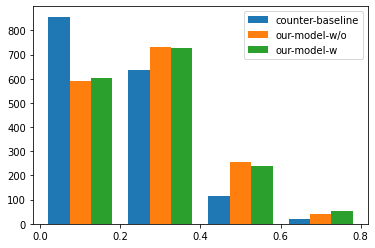

In [395]:

plt.hist([expanded_df.baseline_overlap.tolist(), 
          expanded_df.app2_overlap.tolist(), expanded_df.app3_overlap.tolist()], 
         alpha=1.0, label=['counter-baseline', 'our-model-w/o', 'our-model-w'], bins=np.arange(0,1, 0.2))
plt.xticks(np.arange(0,1, 0.2))
#plt.yscale('log')
plt.legend()
plt.savefig('line_plot.pdf')
plt.show()

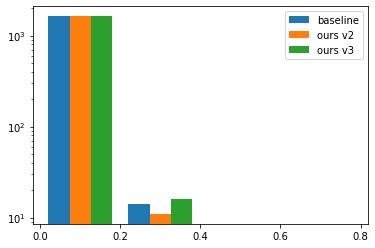

In [221]:
expanded_df['app2_overlap'] = expanded_df.apply(lambda row: utility.overlap_between_attack_and_attacked_premises(row['post'], row['app_v2']), axis=1)
expanded_df['app3_overlap'] = expanded_df.apply(lambda row: utility.overlap_between_attack_and_attacked_premises(row['post'], row['app_v3']), axis=1)
expanded_df['baseline_overlap'] = expanded_df.apply(lambda row: utility.overlap_between_attack_and_attacked_premises(row['post'], row['baseline_final']), axis=1)

plt.hist([expanded_df.baseline_overlap.tolist(), 
          expanded_df.app2_overlap.tolist(), expanded_df.app3_overlap.tolist()], 
         alpha=1.0, label=['baseline', 'ours v2', 'ours v3'], bins=np.arange(0,1, 0.2))
plt.xticks(np.arange(0,1, 0.2))
plt.yscale('log')
plt.legend()
plt.show()

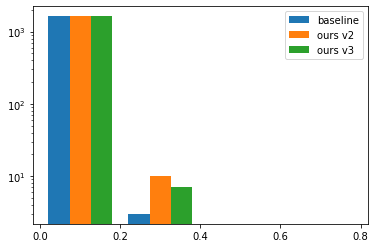

In [222]:
expanded_df['app2_overlap'] = expanded_df.apply(lambda row: utility.overlap_between_attack_and_attacked_premises([row['gt_counter']], row['app_v2']), axis=1)
expanded_df['app3_overlap'] = expanded_df.apply(lambda row: utility.overlap_between_attack_and_attacked_premises([row['gt_counter']], row['app_v3']), axis=1)
expanded_df['baseline_overlap'] = expanded_df.apply(lambda row: utility.overlap_between_attack_and_attacked_premises([row['gt_counter']], row['baseline_final']), axis=1)

plt.hist([expanded_df.baseline_overlap.tolist(), 
          expanded_df.app2_overlap.tolist(), expanded_df.app3_overlap.tolist()], 
         alpha=1.0, label=['baseline', 'ours v2', 'ours v3'], bins=np.arange(0,1, 0.2))
plt.xticks(np.arange(0,1, 0.2))
plt.legend()
plt.yscale('log')
plt.show()

### Prepare data for visualization:

In [71]:
sample_df = expanded_df[['title', 'post', 'premise', 'gt_counter', 'app_v2', 'app_v3', 'app_v4', 'baseline_final']].sample(100)

In [73]:
['title', 'post', 'premise', 'gt_counter', 'ours_with_token_type', 'ours_with_token_type_and_special_tokens', 'ours_with_special_token', 'baseline']
['title', 'post', 'premise', 'gt_counter', 'predictions_1', 'predictions_2', 'predictions_3', 'predictions_4']

sample_df.columns = ['title', 'post', 'premise', 'gt_counter', 'predictions_1', 'predictions_2', 'predictions_3', 'predictions_4']

In [74]:
def prepare_for_vis(df, models_names, output_path):
    
    def annotate_premise(p, weak_premises):
        for x in weak_premises:
            if x in p or p in x:
                return '<weak> ' + p
        return p
    
    #documents
    documents = [{'claim': row['title'],
                  'weak_premise': row['premise'],
                  'premises': row['post'] } for idx, row in df.iterrows()]
    
    with open(output_path+'documents.json', 'w') as f:
        for item in documents:
            f.write(json.dumps(item))
            f.write('\n')

    #reference
    references = df.gt_counter.tolist()
    with open(output_path+'references.txt', 'w') as f:
        for item in references:
            f.write("%s\n" % item)

    for model in models_names:
        #model_json = {'model': model, 'items': [{'document': row['title'] + '  ------  ' + ' '.join(row['post']), 'reference': row['premise'], 'prediction': row[model]} for idx, row in df.iterrows()]}
        #json.dump(model_json, open(output_path+model+'.json', 'w'))
        
        preds = df[model].tolist()
        with open(output_path+model+'.txt', 'w') as f:
            for item in preds:
                f.write("%s\n" % item)

In [75]:
prepare_for_vis(sample_df, ['predictions_1', 'predictions_2', 'predictions_3', 'predictions_4'], './data_files/predictions/')

### Manual Evaluation:

#### Choosing best approach:

In [397]:
ann_folder = './data_files/annotations/'

In [104]:
milad_ranks =[x.strip().split('\t')[1] for x in  open(ann_folder + 'choosing_best_approach - milad-sheet.tsv').readlines()[1:]]
milad_ranks =[[int(x) for x in ranks.split(',')] for ranks in  milad_ranks]
shahbaz_ranks = [x.strip().split('\t')[1] for x in  open(ann_folder + 'choosing_best_approach - shahbaz-sheet.tsv').readlines()[1:]]
shahbaz_ranks =[[int(x) for x in ranks.split(',')] for ranks in  shahbaz_ranks]

In [107]:
all_ranks = milad_ranks + shahbaz_ranks

In [113]:
first_ranks = [x[0] for x in all_ranks]
print('most common approach in first rank: ',max(set(first_ranks), key=first_ranks.count))
      
second_ranks = [x[1] for x in all_ranks]
print('most common approach in second rank: ',max(set(second_ranks), key=second_ranks.count))
      
third_ranks = [x[2] for x in all_ranks]
print('most common approach in third rank: ',max(set(third_ranks), key=third_ranks.count))

most common approach in first rank:  1
most common approach in second rank:  1
most common approach in third rank:  3


In [132]:
data = []
for app in [1,2,3]:
    app_ranks = ['predictions-{}'.format(app)]
    for rank in [1,2,3]:
        app_perc = [x[rank-1] for x in all_ranks].count(app)/100
        app_ranks.append(app_perc)
    data.append(app_ranks)

In [133]:
print(tabulate(data, headers=['rank-1', 'rank-2', 'rank3']))

                 rank-1    rank-2    rank3
-------------  --------  --------  -------
predictions-1      0.5       0.41     0.09
predictions-2      0.41      0.4      0.19
predictions-3      0.09      0.19     0.72


#### Baseline vs Approach:

In [398]:
from collections import Counter
from sklearn.metrics import cohen_kappa_score
from nltk import agreement
from scipy.stats import kendalltau

In [399]:
#making it like a ranking list, so if user picked 1 then the ranking will be [1, 4]
def extend_s(s):
    o = []
    for x in s:
        o.append(x)
        o.append('1' if x=='4' else '4')
    return o

In [400]:
timon_ranks =[x.strip().split(',')[1:] for x in  open(ann_folder + 'timon_eval_template.csv').readlines()[1:]]
max_ranks =[x.strip().split(',')[1:] for x in  open(ann_folder + 'max_eval_template.csv').readlines()[1:]]
weifan_ranks =[x.strip().split(',')[1:] for x in  open(ann_folder + 'weifan_eval_template.csv').readlines()[1:]]

In [401]:
rel_scores = [[x[0][0], x[1][0], x[2][0]] for x in zip(timon_ranks, max_ranks, weifan_ranks)]
app_scores = [[x[0][1], x[1][1], x[2][1]] for x in zip(timon_ranks, max_ranks, weifan_ranks)]

Relevant to the weak premise:

In [402]:
majority_vote = [Counter(x).most_common()[0][0] for x in rel_scores]

print('Approach was selected:', majority_vote.count('1')/50)
print('Baseline was selected:', majority_vote.count('4')/50)

Approach was selected: 0.56
Baseline was selected: 0.44


In [406]:
absolute_scores = [s for row in rel_scores for s in row]
print('Approach was selected:', absolute_scores.count('1')/150)
print('Baseline was selected:', absolute_scores.count('4')/150)

Approach was selected: 0.5733333333333334
Baseline was selected: 0.4266666666666667


Appropriatness:

In [364]:
majority_vote = [Counter(x).most_common()[0][0] for x in app_scores]

print('Approach was selected:', majority_vote.count('1')/50)
print('Baseline was selected:', majority_vote.count('4')/50)

Approach was selected: 0.56
Baseline was selected: 0.44


In [407]:
absolute_scores = [s for row in app_scores for s in row]
print('Approach was selected:', absolute_scores.count('1')/150)
print('Baseline was selected:', absolute_scores.count('4')/150)

Approach was selected: 0.5666666666666667
Baseline was selected: 0.43333333333333335


In [365]:
all_scores = rel_scores + app_scores

In [312]:
ann1, ann2, ann3 = zip(*rel_scores)
ann1 = extend_s(ann1)
ann2 = extend_s(ann2)
ann3 = extend_s(ann3)
print('Avg Kendalls for the task of relevancy: ', (kendalltau(ann1, ann2)[0] + kendalltau(ann1, ann3)[0] + kendalltau(ann2, ann3)[0])/3)

Avg Kendalls for the task of relevancy:  0.4133333333333334


In [313]:
ann1, ann2, ann3 = zip(*app_scores)
ann1 = extend_s(ann1)
ann2 = extend_s(ann2)
ann3 = extend_s(ann3)
print('Avg Kendalls for the task of appropriateness: ', (kendalltau(ann1, ann2)[0] + kendalltau(ann1, ann3)[0] + kendalltau(ann2, ann3)[0])/3)

Avg Kendalls for the task of appropriateness:  0.22666666666666668
